In [4]:
import sys

sys.path.append("../..")

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_mas.common.orthotopes.base import batch_create_hypercube

In [594]:
from matplotlib.patches import Rectangle
from scipy.interpolate import griddata

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

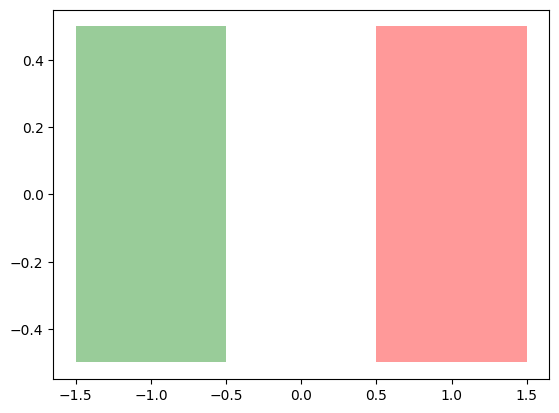

In [595]:
side_lengths = torch.as_tensor([1.0, 1.0])
x1 = torch.as_tensor([-1, 0])
x2 = torch.as_tensor([1, 0])

X = torch.vstack([x1, x2])
H = batch_create_hypercube(X, side_lengths)

ax = plt.gca()
plt.scatter(X[:, 0], X[:, 1], alpha=0)
plot_hypercubes(ax, [H[0]], color="g")
plot_hypercubes(ax, [H[1]], color="r")

In [596]:
def activation(x):
    return torch.exp(-())

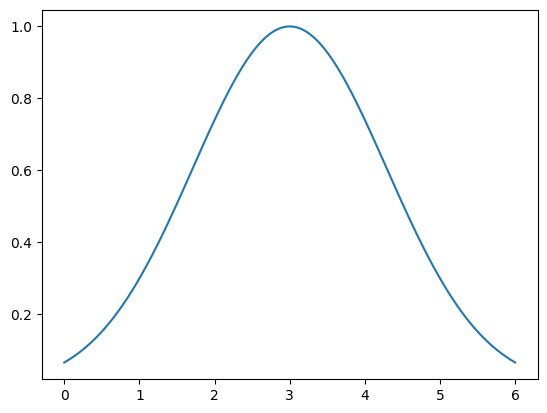

In [597]:
def dim_activated(x: torch.Tensor, h: torch.Tensor, limit_probability: float = 0.3):
    """Return activation for one dimension of one point for one hyperrectangle

    Args:
        x (torch.Tensor): (batch_size,)
        h (torch.Tensor): (2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.
    """
    low, high = h[0], h[1]
    mu = (high + low) / 2
    sigma = torch.sqrt(-(high-mu)**2/(2*torch.log(torch.as_tensor(limit_probability))))
    return torch.exp(-(x-mu)**2/(2*sigma**2))


h1 = torch.as_tensor([1, 5])
x = torch.linspace(0, 6, 100)
a = dim_activated(x, h1)

plt.plot(x, a)

torch.Size([2, 100])


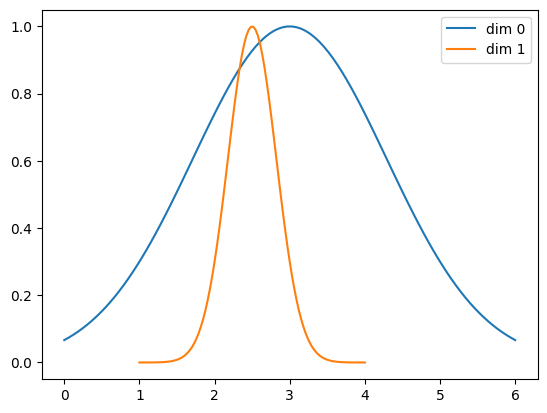

In [598]:
_dims_activated = torch.vmap(dim_activated, in_dims=(0, 0, None))

def dims_activated(x: torch.Tensor, h: torch.Tensor, limit_probability: float = 0.3):
    """Return activation for each dimension for one point for one hyperrectangle

    Args:
        x (torch.Tensor): (batch_size, in_dim)
        h (torch.Tensor): (in_dim, 2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.
    """
    return _dims_activated(x, h, limit_probability)

h1 = torch.as_tensor([[1, 5], [2, 3]])
x = torch.vstack([torch.linspace(0, 6, 100), torch.linspace(1, 4, 100)])
a = dims_activated(x, h1)
print(x.shape)
for i in range(a.size(0)):
    plt.plot(x[i, :], a[i, :], label=f"dim {i}")
plt.legend()

torch.Size([100, 2]) torch.Size([2, 2])
tensor([1, 2]) tensor([5, 3])
tensor([3.0000, 2.5000])
tensor([-4.0000, -0.2500])
torch.Size([100, 2]) torch.Size([2, 2])


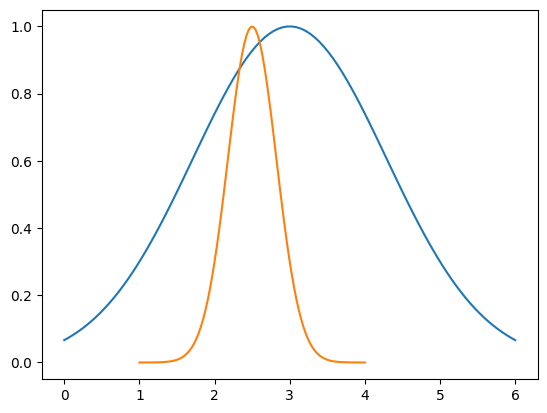

In [599]:
def dim_activated(x: torch.Tensor, h: torch.Tensor, limit_probability: torch.Tensor):
    """Return activation for one dimension of one point for one hyperrectangle

    Args:
        x (torch.Tensor): (in_dims,)
        h (torch.Tensor): (in_dims, 2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.
    """
    print(x.shape, h.shape)
    low, high = h[:, 0], h[:, 1]
    print(low, high)
    mu = (high + low) / 2
    print(mu)
    print(-(high-mu)**2)
    sigma = torch.sqrt(-(high-mu)**2/(2*torch.log(limit_probability)))
    return torch.exp(-(x-mu)**2/(2*sigma**2))


h1 = torch.as_tensor([[1, 5], [2, 3]])
x = torch.stack([torch.linspace(0, 6, 100), torch.linspace(1, 4, 100)]).T
a = dim_activated(x, h1, torch.as_tensor(0.3))
print(x.shape, h1.shape)

plt.plot(x, a)
plt.show()

torch.Size([100, 2]) torch.Size([1, 2, 2]) torch.Size([1, 100, 2])


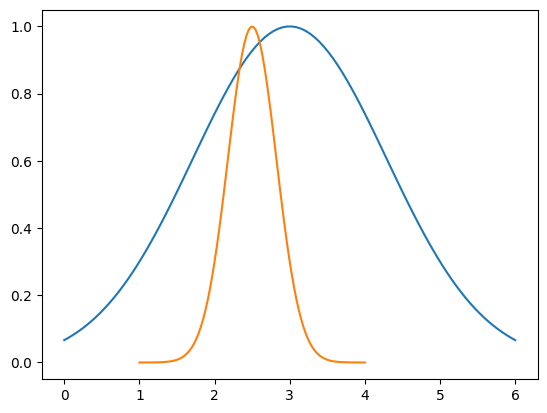

In [600]:
def dim_activated(x: torch.Tensor, h: torch.Tensor, limit_probability: torch.Tensor):
    """Return activation for one dimension of one point for one hyperrectangle

    Args:
        x (torch.Tensor): (in_dims,)
        h (torch.Tensor): (in_dims, 2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.
    """
    low, high = h[:, 0], h[:, 1]
    mu = (high + low) / 2
    sigma = torch.sqrt(-(high-mu)**2/(2*torch.log(limit_probability)))
    return torch.exp(-(x-mu)**2/(2*sigma**2))

batch_dims_activated = torch.vmap(dim_activated, in_dims=(None, 0, None)) # (batch_size, in_dims), (h_batch_size, in_dims, 2), ()

h1 = torch.as_tensor([[1, 5], [2, 3]]).unsqueeze(0)
x = torch.stack([torch.linspace(0, 6, 100), torch.linspace(1, 4, 100)]).T
a = batch_dims_activated(x, h1, torch.as_tensor(0.3))
print(x.shape, h1.shape, a.shape)

plt.plot(x, a[0])
plt.show()

In [601]:
n_step = 30
parameters = torch.randn((n_step * 2, 1), requires_grad=True)

target = 0.
print(parameters.shape)
optimizer = torch.optim.Adam([{"params": parameters}], lr=1e-1)

for e in range(n_step):
    print(parameters.shape)
    loss = (parameters**2).mean()
    print("LOSS:", loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([60, 1])
torch.Size([60, 1])
LOSS: tensor(1.3351, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(1.1605, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(1.0059, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.8699, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.7513, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.6485, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.5596, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.4828, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.4165, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.3594, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.3104, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.2683, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.2323, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.2013, grad_fn=<MeanBackward0>)
torch.Size([60, 1])
LOSS: tensor(0.1747, grad_fn=<MeanBa

In [602]:
for state in optimizer.state_dict()["state"]:
    for internal in optimizer.state_dict()["state"][state]:
        print(f"{state}:{internal}:", optimizer.state_dict()["state"][state][internal].shape)

0:step: torch.Size([])
0:exp_avg: torch.Size([60, 1])
0:exp_avg_sq: torch.Size([60, 1])


In [603]:
remove_mask = torch.zeros(parameters.size(0), dtype=torch.bool)
remove_mask[0] = True

optimizer_state = optimizer.state_dict()["state"]
for group in optimizer_state:
    state_group = optimizer_state[group]
    for p in state_group:
        print(state_group[p].size())
        size = state_group[p].size()
        if size and state_group[p].size(0) == remove_mask.size(0):
            print("OUI", remove_mask.shape, state_group[p].shape)
            state_group[p] = state_group[p][~remove_mask]
            
optimizer_param_groups = optimizer.param_groups
for group in optimizer_param_groups:
    params = group["params"]
    for i in range(len(params)):
        group["params"][i] = params[i][~remove_mask]

optimizer.load_state_dict(optimizer_state)

torch.Size([])
torch.Size([60, 1])
OUI torch.Size([60]) torch.Size([60, 1])
torch.Size([60, 1])
OUI torch.Size([60]) torch.Size([60, 1])


KeyError: 'param_groups'

In [580]:
optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)>

In [578]:
optimizer_param_groups = optimizer.param_groups
for group in optimizer_param_groups:
    for param in group["params"]:
        print(param.shape)

torch.Size([60, 1])


In [579]:
for group in optimizer_state:
    param_group = optimizer_state[group]
    for p in param_group:
        print(param_group[p].size())

torch.Size([])
torch.Size([59, 1])
torch.Size([59, 1])
